In [1]:
import numpy as np
import astropy as ap
from astropy import units as u
import matplotlib.pyplot as plt
import ugradio
import time

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [7]:
ugradio.timing.julian_date?

### Functions to Use

    ifm.stow
    ifm.maintenance
    ifm.get_pointing where is telescope now
    ifm.point(alt,az) where do you want it to point
    hpm.read_voltage
    hpm.start_recording(dt)
    hpm.get_recording_data()
    hpm.end_recording()
    ugradio.coord.sunpos(jd)
    ugradio.coord.moonpos(jd,lat,lon,alt)
    ugradio.coord.get_altaz(ra, dec, jd, lat, lon, alt)
    ugradio.coord.precess(ra, dec, jd, equinox)

In [2]:
# ifm = ugradio.interf.Interferometer()
# hpm = ugradio.hp_multi.HP_Multimeter()


In [2]:
# Crab Nebula
print('Crab Nebula coordinates are {}'.format(ap.coordinates.SkyCoord('05:34:31.95', '+22:00:52.1', unit = (u.hourangle, u.deg))))

# Orion Nebula
print('Orion Nebula coordinates are {}'.format(ap.coordinates.SkyCoord('05:35:17.3', '-05:23:28', unit = (u.hourangle, u.deg))))

# M17
print('M17 coordinates are {}'.format(ap.coordinates.SkyCoord('18:20:26', '-16:10.6', unit = (u.hourangle, u.deg))))

# Cygnus A 
print('CygA coordinates are {}'.format(ap.coordinates.SkyCoord('19:59:28.357', '+40:44:02.1', unit = (u.hourangle, u.deg))))

# Cas A
print('Cas A coordinates {}'.format(ap.coordinates.SkyCoord('23:23:24', '+58:48.9', unit = (u.hourangle, u.deg))))

Crab Nebula coordinates are <SkyCoord (ICRS): (ra, dec) in deg
    ( 83.633125,  22.01447222)>
Orion Nebula coordinates are <SkyCoord (ICRS): (ra, dec) in deg
    ( 83.82208333, -5.39111111)>
M17 coordinates are <SkyCoord (ICRS): (ra, dec) in deg
    ( 275.10833333, -16.17666667)>
CygA coordinates are <SkyCoord (ICRS): (ra, dec) in deg
    ( 299.86815417,  40.73391667)>
Cas A coordinates <SkyCoord (ICRS): (ra, dec) in deg
    ( 350.85,  58.815)>


In [12]:
def julianDayArray(hrs, dt, initUnixT):
    interval = hrs*3600./dt
    secInt = dt
    jds = []
    for i in range(int(interval)):
        jds.append(ugradio.timing.julian_date(initUnixT + secInt*i))
    # actual julian data to put into alt az functions
    jds = np.array(jds)
    # start from 0 and convert to hours for plot
    jdHrs = []
    jdHrs = (jds - jds[0])*24
    return jds, np.array(jdHrs)

In [7]:
def findAltAz(ra, dec, jd_array):
    altArr = []
    azArr = []
    for j in jd_array:
        raP, decP = ugradio.coord.precess(ra, dec, jd = j)
        alt, az = ugradio.coord.get_altaz(raP, decP, jd =j)
        altArr.append(alt)
        azArr.append(az)
    return np.array(altArr), np.array(azArr)

In [8]:
def moonAltAz(jd_array):
    altArr = []
    azArr = []
    for j in jd_array:
        raM,decM = ugradio.coord.moonpos(jd = j)
        alt, az = ugradio.coord.get_altaz(raM, decM, jd = j)
        altArr.append(alt)
        azArr.append(az)
    return np.array(altArr), np.array(azArr)

In [9]:
def sunAltAz(jd_array):
    altArr = []
    azArr = []
    for j in jd_array:
        raS, decS = ugradio.coord.sunpos(jd = j)
        alt, az = ugradio.coord.get_altaz(raS, decS, jd = j)
        altArr.append(alt)
        azArr.append(az)
    return np.array(altArr), np.array(azArr)

In [10]:
def corrections(altitude, azimuth):
    for al, az, i in zip(altitude, azimuth, range(len(altitude))):
        if az < 90:
            azimuth[i] = az + 180
            altitude[i] = abs(180 - altitude[i])
        elif az > 300:
            azimuth[i] = az - 180
            altitude[i] = abs(180 - altitude[i])
    return altitude, azimuth

## WE WANT TO RUN THINGS ON REAL TIME INSTEAD BECAUSE THIS DID NOT WORK !! :((((


In [ ]:

def collect_data(correctAlt, correctAz, dt, n, dataFile, pointfileName):
    start_time = time.time()
    
    with open('{}'.format(pointfileName), 'w') as pointFile:
        pointFile.write('{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\n'.format('Julian Date','Measured Alt','Measured Az','Correct Alt','Correct Az','westAltitude', 'westAzimuth', 'eastAltitude', 'eastAzimuth', ))

        ifm.point(correctAlt[0], correctAz[0])
        hpm.start_recording(n)

        ct = 0
        record_time = time.time()
        for al, az in zip(correctAlt, correctAz):
            ifm.point(al, az)
            get_point = ifm.get_pointing()
            valAltAz = get_point.values()
            pointFile.write('{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\n'.format(julian_Crab[ct], CrabAlt[ct], CrabAz[ct], al, az, valAltAz[0][0], valAltAz[0][1], valAltAz[1][0], valAltAz[1][1]))
            print('We are looking here:\n{}\t{}\t{}\t{}\n'.format(valAltAz[0][0], 
valAltAz[0][1], valAltAz[1][0], valAltAz[1][1]))
            
   
            point_time = time.time()
            
            time.sleep(dt)
            current_time = time.time()
            if current_time - point_time >= dt:
                volts, times = hpm.get_recording_data()
                np.savez('{}'.format(dataFile), v = volts, tt = times)   
            ct += 1
    vend, tend = hpm.end_recording()
    np.savez('{}_last'.format(dataFile), vv = vend, ttt = tend) 
    return volts, times

In [13]:
def collect_data(ra, dec, hrs, dt, n, dataFile, pointfileName):
    with open('{}'.format(pointfileName), 'w') as pointFile:
        pointFile.write('{}\t{}\t{}\t{}\n'.format('westAltitude', 'westAzimuth', 'eastAltitude', 'eastAzimuth'))
        
        unix = ugradio.timing.unix_time()
        jds, jdsHr = julianDayArray(hrs, dt, unix)
        alts, azs = findAltAz(ra, dec, jds)
        correctAlt, correctAz = corrections(alts, azs)

        ct = 0
        for al, az in zip(correctAlt, correctAz):
            ifm.point(al, az)
            get_point = ifm.get_pointing()
            valAltAz = get_point.values()
            pointFile.write('{}\t{}\t{}\t{}\n'.format(valAltAz[0][0], valAltAz[0][1], valAltAz[1][0], valAltAz[1][1]))

            hpm.start_recording(n)
            start_time = time.time()
            time.sleep(dt*60)
            current_time = time.time()
            if current_time - start_time >= dt*60:
                volts, times = hpm.end_recording()
                np.savez('{}_{}'.format(dataFile, ct), v = volts, tt = times)   
                ct += 1

In [30]:
jdArr, jdHrss = julianDayArray(.1,3,ugradio.timing.unix_time())
tAlt, tAz = findAltAz(350.85,  58.815, jdArr)
print(tAlt, tAz)
cAlt, cAz = corrections(tAlt, tAz)
print(cAlt, cAz)

(array([ 32.24666852,  32.60969758]), array([ 37.61786487,  37.78115258]))
(array([ 147.75333148,  147.39030242]), array([ 217.61786487,  217.78115258]))


In [23]:
jd_times, jd_72hrs = julianDayArray(35, 20*60, ugradio.timing.unix_time())

In [24]:
# Find Coordinates for Objects of Interest
crabAlt, crabAz = findAltAz(83.633125,  22.01447222, jd_times)
orionAlt, orionAz = findAltAz(83.82208333, -5.39111111, jd_times)
M17Alt, M17Az = findAltAz(275.10833333, -16.17666667, jd_times)
CygAlt, CybAz = findAltAz(299.86815417,  40.73391667, jd_times)
CasAlt, CasAz = findAltAz(350.85,  58.815, jd_times)
# moonAlt, moonAz = moonAltAz(jd_moon)
sunAlt, sunAz = sunAltAz(jd_times)

In [12]:
195.33396/60.

3.255566

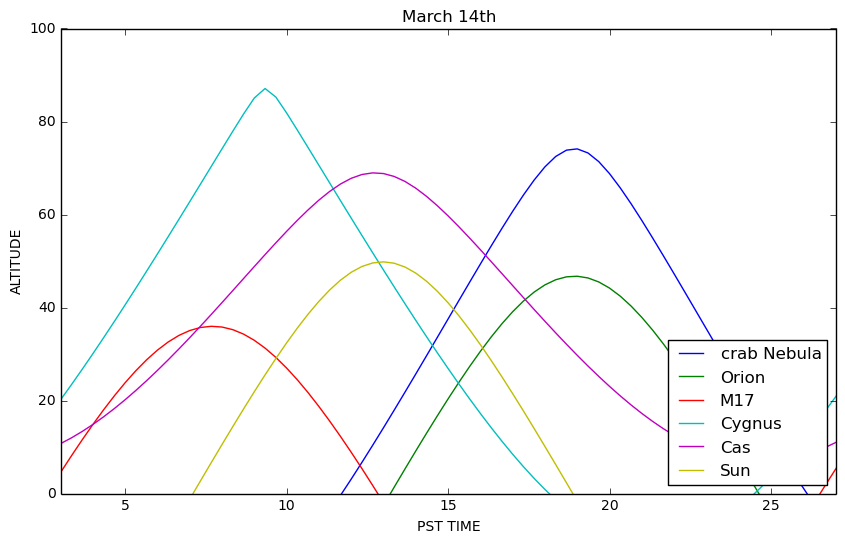

In [30]:
plt.figure(figsize = (10,6))
plt.plot(jd_72hrs-6, crabAlt, label = 'crab Nebula')
plt.plot(jd_72hrs-6, orionAlt, label = 'Orion')
plt.plot(jd_72hrs-6, M17Alt, label = 'M17')
plt.plot(jd_72hrs-6, CygAlt, label = 'Cygnus')
plt.plot(jd_72hrs-6, CasAlt, label = 'Cas')
# plt.plot(jd_24moon+3, moonAlt, label = 'Moon', c = 'navy')
plt.plot(jd_72hrs-6, sunAlt, 'y', label = 'Sun')
plt.ylim(0,100)
plt.xlim(3,24+3)
plt.legend(loc = 'lower right')
plt.xlabel('PST TIME')
plt.ylabel('ALTITUDE')
plt.title('March 14th')